In [1]:
import glob
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
import datetime
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from sklearn.cluster import KMeans
from jupyterthemes import jtplot
jtplot.style()
%matplotlib inline

C:\Users\joshua.bramall\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [12]:
#path =r'C:\DRO\DCL_rawdata_files' # use your path
allFiles = glob.glob("*-*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0, encoding='latin_1')
    list_.append(df)
df = pd.concat(list_)

In [25]:
df.groupby(['follows_subject','verified'])['user_id'].count()

follows_subject  verified
1.017281e+09     False        7763
                 True          104
2.875502e+09     False       11328
                 True          189
8.743764e+17     False       21882
                 True           80
8.772527e+17     False         422
                 True           10
9.196453e+17     False         998
                 True           19
Name: user_id, dtype: int64

In [28]:
df['user_id'].unique().shape # overlap of ids across subsets

(36253,)

In [32]:
df.groupby(['verified'])['user_id'].count()

verified
False    42393
True       402
Name: user_id, dtype: int64

In [29]:
df2 = df.drop_duplicates(subset='user_id',keep='first')

In [31]:
df2.groupby(['verified'])['user_id'].count()

verified
False    35945
True       307
Name: user_id, dtype: int64

In [19]:
list(df)

['contributors_enabled',
 'created_at',
 'default_profile',
 'default_profile_image',
 'description',
 'favourites_count',
 'followers_count',
 'friends_count',
 'geo_enabled',
 'lang',
 'listed_count',
 'location',
 'name',
 'profile_background_color',
 'profile_background_image_url',
 'profile_background_tile',
 'profile_banner_url',
 'profile_image_url',
 'profile_link_color',
 'profile_sidebar_fill_color',
 'profile_text_color',
 'protected',
 'screen_name',
 'status_created_at',
 'status_hashtags',
 'status_lang',
 'statuses_count',
 'text',
 'time_zone',
 'url',
 'user_id',
 'user_mentions',
 'verified',
 'follows_subject']

In [321]:
mappings = {"contributors_enabled": {"False": 0, "True": 1},"default_profile": {"False": 0, "True": 1},
            "default_profile_image": {"False": 0, "True": 1},"geo_enabled": {"False": 0, "True": 1}
           }

In [322]:
en_maps = {'en-gb': 'en', "en-GB": 'en'} #merge gb english with general english
df['lang'] = df['lang'].replace(en_maps)
df['status_lang'] = df['status_lang'].replace(en_maps)
#df.loc[df['lang'] != 'en', 'lang'] = 1 #encode non english as 1
#df['lang'].unique()

In [323]:
#convert datetime fields
df['created_at'] = pd.to_datetime(df['created_at'])
df['status_created_at'] = pd.to_datetime(df['status_created_at'])
#generate time distance features
df['age'] = datetime.date(2018, 2, 9) - df['created_at']
df['age'] = df['age'].dt.days
df['activity_statuses'] = df['statuses_count'] / df['age']
df['activity_friends'] = df['friends_count'] / df['age']
df['activity_last_status'] = datetime.date(2018, 2, 9) - df['status_created_at']
df['activity_last_status'] = df['activity_last_status'].dt.seconds

In [324]:
# Feature Scaling of variables
#X = X.astype(int)
#scaler = StandardScaler()
#X = scaler.fit_transform(X)

In [41]:
df['protected'].value_counts()

False    37873
True      3937
False      900
True        95
en           5
Name: protected, dtype: int64

In [42]:
#df.dtypes

In [326]:
#select features for kmodes clustering
features = [
 'user_id',
 'favourites_count',
 'followers_count',
 'friends_count',
 'listed_count',
 'statuses_count',
 'activity_statuses',
 'activity_friends',
 'activity_last_status',
 'age'
 'contributors_enabled',
 #'created_at',
 'default_profile',
 'default_profile_image',
 #'description',
 'geo_enabled',
 'lang',
 #'location',
 #'name',
 #'profile_background_color',
 #'profile_background_image_url',
 #'profile_background_tile',
 #'profile_banner_url',
 #'profile_image_url',
 #'profile_link_color',
 #'profile_sidebar_fill_color',
 #'profile_text_color',
 'protected',
 #'screen_name',
 'status_created_at',
 #'status_hashtags',
 'status_lang',
 #'text',
 'time_zone',
 #'url',
 #'user_mentions',
 'verified',
 #'follows_subject',
]

In [327]:
df = df[features]

In [328]:
df.describe()

,user_id,favourites_count,followers_count,friends_count,listed_count,statuses_count,activity_statuses,activity_friends,activity_last_status
count,1.017000e+03,1017.000000,1.017000e+03,1.017000e+03,1017.000000,1017.000000,1017.000000,1017.000000,981.000000
mean,3.326716e+17,9246.401180,3.891214e+04,3.187525e+04,96.929204,13497.054081,9.348822,85.110389,35167.731906
std,4.242292e+17,22049.820106,1.173876e+05,7.669616e+04,288.989454,33697.292278,22.707394,175.668456,17858.036210
min,1.057211e+06,0.000000,0.000000e+00,1.300000e+01,0.000000,0.000000,0.000000,0.027317,177.000000
25%,3.811644e+08,27.000000,7.210000e+02,1.207000e+03,5.000000,225.000000,0.553681,0.787084,26187.000000
50%,2.937702e+09,909.000000,2.883000e+03,3.766000e+03,24.000000,1774.000000,2.068376,3.973918,31233.000000
75%,8.480794e+17,7164.000000,3.506500e+04,3.049900e+04,86.000000,10932.000000,7.915198,81.008439,44401.000000
max,9.612170e+17,223356.000000,2.026718e+06,1.316518e+06,6839.000000,417299.000000,261.084192,2002.000000,86035.000000


In [329]:
# Taking care of missing data
cols = list(df)
fill_NaN = Imputer(missing_values=np.nan, strategy='mean', axis=1)
df = pd.DataFrame(fill_NaN.fit_transform(df))
df.columns = cols

C:\Users\joshua.bramall\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


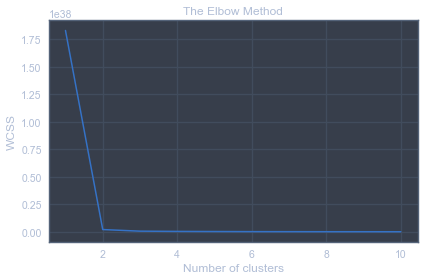

In [330]:
# Using the elbow method to find the optimal number of clusters
x = df.as_matrix(columns=None)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [331]:
#kprototypes module handles mix of categorical and continuous features - https://github.com/nicodv/kmodes

# stocks with their market caps, sectors and countries
syms = df['user_id'].values
X = df.drop('user_id', 1).values
X = X.astype(float)
#label encode categorical features
#le = LabelEncoder()
#le.fit_transform(X)

kproto = KPrototypes(n_clusters=4, init='Cao', verbose=2)
clusters = kproto.fit_predict(X, categorical=[])

# Print cluster centroids of the trained model.
print(kproto.cluster_centroids_)
# Print training statistics
print(kproto.cost_)
print(kproto.n_iter_)

for s, c in zip(syms, clusters):
    print("Symbol: {}, cluster:{}".format(s, c))

Initialization method and algorithm are deterministic. Setting n_init to 1.


NotImplementedError: No categorical data selected, effectively doing k-means. Present a list of categorical columns, or use scikit-learn's KMeans instead.

In [ ]:
import numpy as np
from kmodes.kprototypes import KPrototypes

# stocks with their market caps, sectors and countries
syms = np.genfromtxt('stocks.csv', dtype=str, delimiter=',')[:, 0]
X = np.genfromtxt('stocks.csv', dtype=object, delimiter=',')[:, 1:]
X[:, 0] = X[:, 0].astype(float)

kproto = KPrototypes(n_clusters=4, init='Cao', verbose=2)
clusters = kproto.fit_predict(X, categorical=[1, 2])

# Print cluster centroids of the trained model.
print(kproto.cluster_centroids_)
# Print training statistics
print(kproto.cost_)
print(kproto.n_iter_)

for s, c in zip(syms, clusters):
    print("Symbol: {}, cluster:{}".format(s, c))